#  Demonstration notebook for qiskit_pulse

In [1]:
from qiskit import transpile, schedule, QuantumCircuit
from qiskit.circuit import Gate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeHanoi
from qiskit import pulse
from qiskit.pulse.library import Gaussian, GaussianSquare
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

#  Backend configuration

In [3]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='MY_IBM_QUANTUM_TOKEN') # Copy & Paste API-Token from IBM-Quantum Dashboard page

In [4]:
service.backends()

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>]

In [5]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

fake_hanoi 27 ['id', 'rz', 'sx', 'x', 'cx', 'reset']
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


In [6]:
BACKEND = service.get_backend('ibm_kyoto')
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

ibm_kyoto 127 ['ecr', 'id', 'rz', 'sx', 'x']
[[0, 14], [1, 0], [1, 2], [3, 2], [4, 3], [4, 5], [6, 5], [7, 6], [8, 7], [8, 9], [8, 16], [9, 10], [11, 10], [11, 12], [12, 13], [15, 4], [16, 26], [17, 12], [17, 30], [18, 14], [18, 19], [19, 20], [21, 20], [22, 15], [22, 21], [22, 23], [23, 24], [25, 24], [25, 26], [27, 26], [27, 28], [28, 29], [28, 35], [30, 29], [30, 31], [31, 32], [32, 36], [33, 20], [33, 39], [34, 24], [34, 43], [37, 38], [38, 39], [39, 40], [40, 41], [42, 41], [43, 42], [44, 43], [44, 45], [46, 45], [47, 35], [47, 46], [48, 47], [49, 48], [49, 55], [50, 49], [50, 51], [51, 36], [52, 37], [53, 41], [53, 60], [54, 45], [54, 64], [55, 68], [56, 52], [57, 56], [57, 58], [59, 58], [59, 60], [61, 60], [62, 61], [62, 63], [63, 64], [64, 65], [65, 66], [67, 66], [67, 68], [68, 69], [70, 69], [71, 58], [72, 62], [73, 66], [73, 85], [74, 70], [75, 90], [76, 75], [76, 77], [77, 71], [77, 78], [79, 78], [79, 91], [80, 79], [81, 72], [81, 80], [82, 81], [82, 83], [83, 92], [84, 8

In [7]:
list(config.to_dict().keys())
#config.to_dict()
#config.to_dict()['backend_name']

['backend_name',
 'backend_version',
 'n_qubits',
 'basis_gates',
 'gates',
 'local',
 'simulator',
 'conditional',
 'open_pulse',
 'memory',
 'max_shots',
 'coupling_map',
 'dynamic_reprate_enabled',
 'supported_instructions',
 'rep_delay_range',
 'default_rep_delay',
 'max_experiments',
 'sample_name',
 'n_registers',
 'credits_required',
 'online_date',
 'description',
 'dt',
 'dtm',
 'processor_type',
 'parametric_pulses',
 'allow_q_object',
 'clops',
 'clops_h',
 'clops_v',
 'coords',
 'measure_esp_enabled',
 'multi_meas_enabled',
 'parallel_compilation',
 'quantum_volume',
 'qubit_channel_mapping',
 'supported_features',
 'timing_constraints',
 'uchannels_enabled',
 'url',
 'n_uchannels',
 'u_channel_lo',
 'meas_levels',
 'qubit_lo_range',
 'meas_lo_range',
 'meas_kernels',
 'discriminators',
 'rep_times',
 'meas_map',
 'acquisition_latency',
 'conditional_latency',
 'hamiltonian',
 'channels']

# From quantum circuit to pulse schedule : Transpilation

## qubit mapping

In [8]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

fake_hanoi 27 ['id', 'rz', 'sx', 'x', 'cx', 'reset']
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


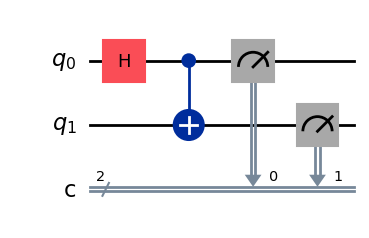

In [9]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.draw('mpl')

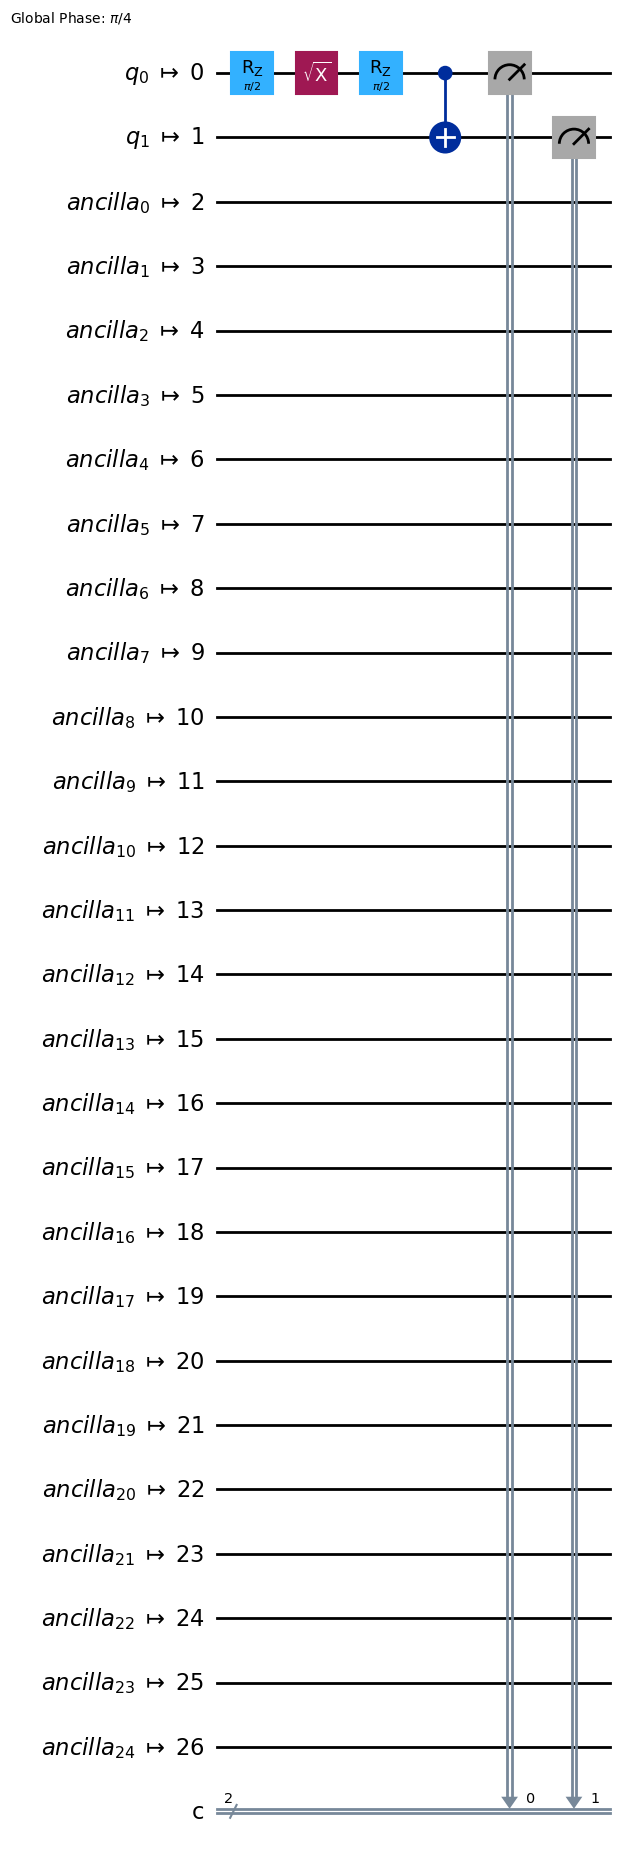

In [10]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=True)

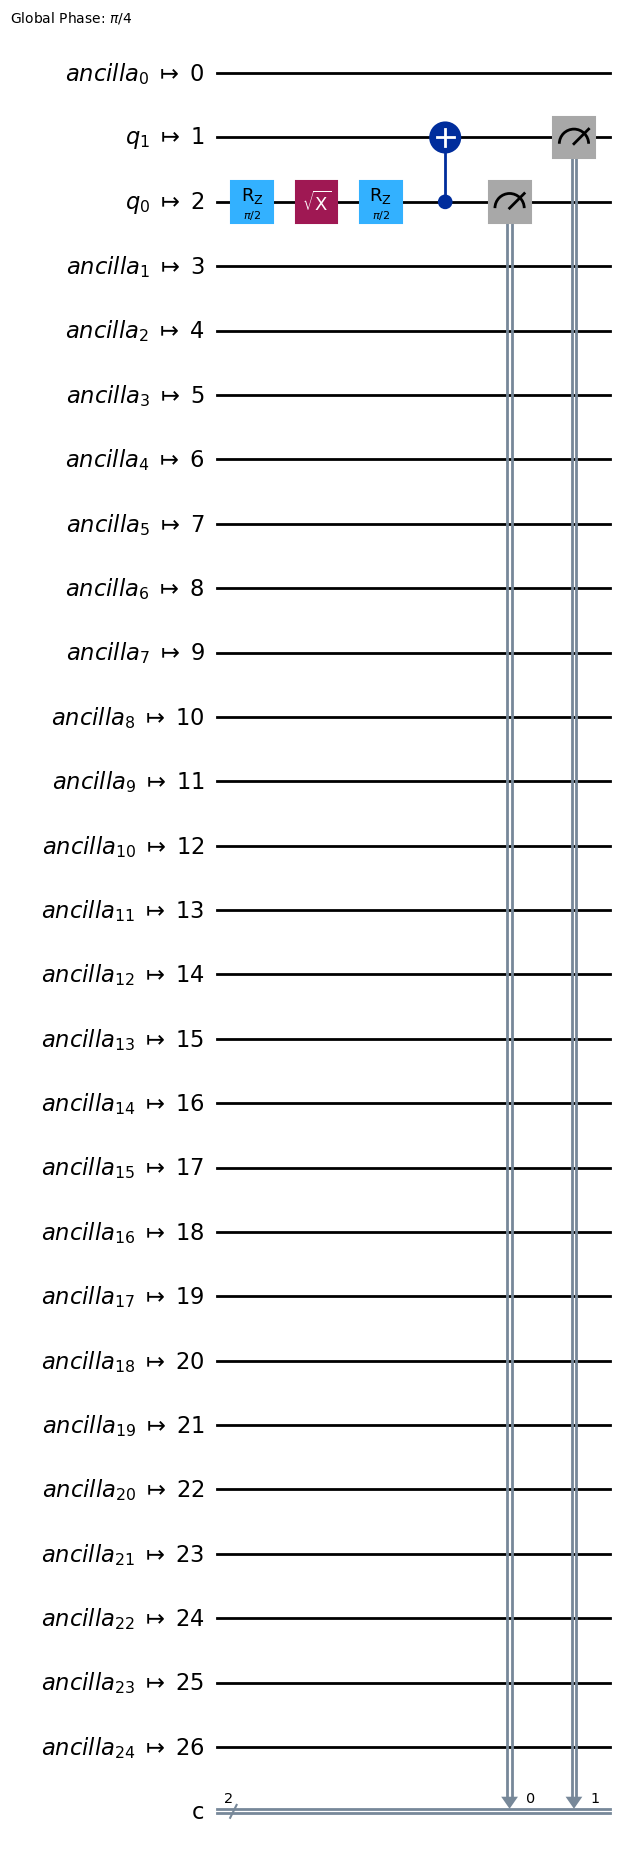

In [11]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[2,1])
transpiled_circ.draw('mpl', idle_wires=True)

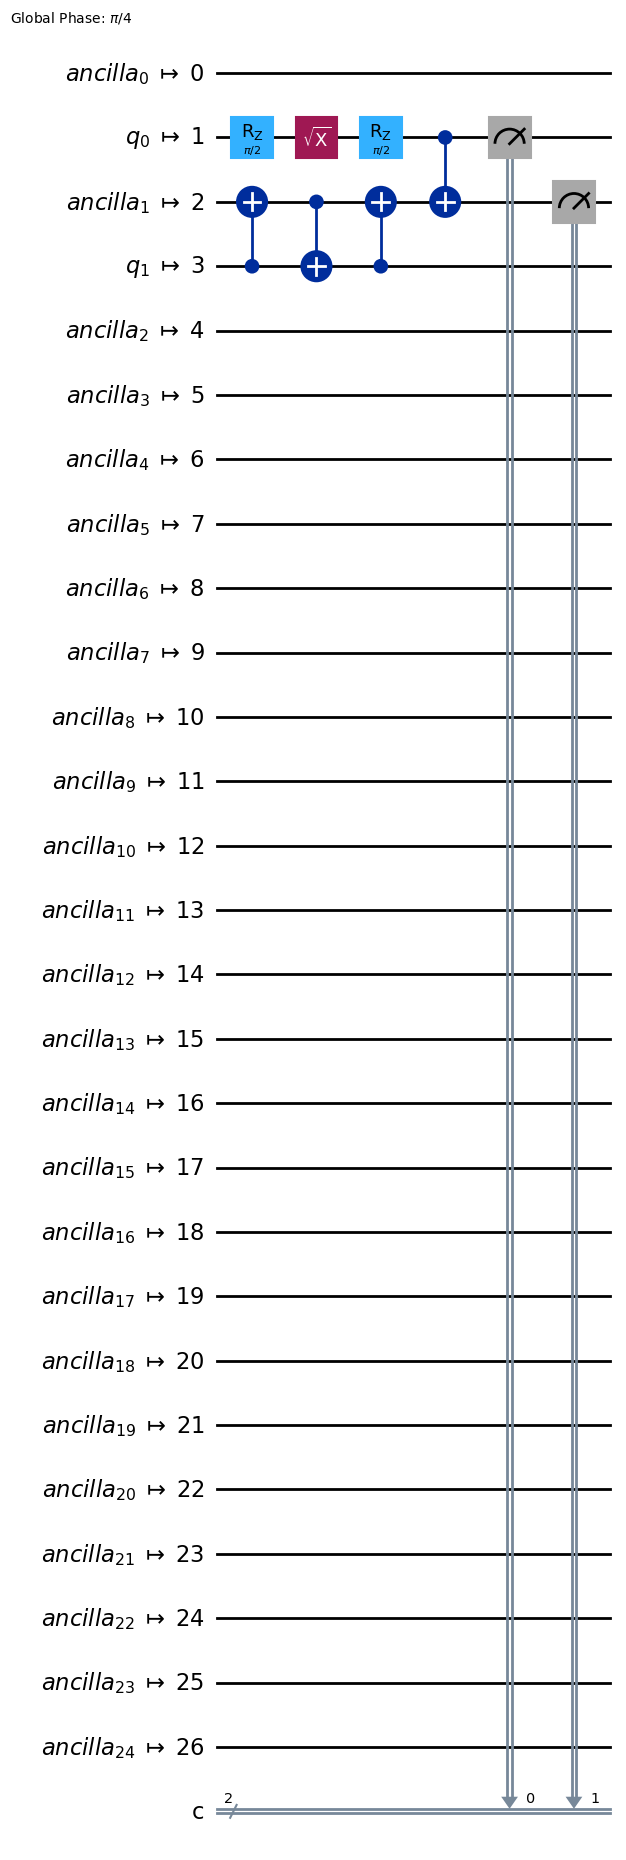

In [12]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[1,3])
transpiled_circ.draw('mpl', idle_wires=True)

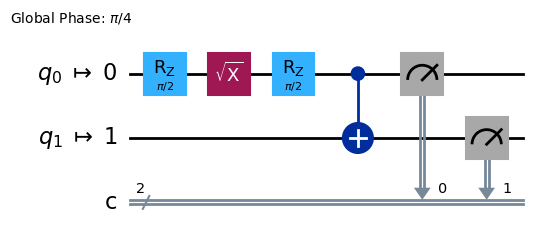

In [13]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

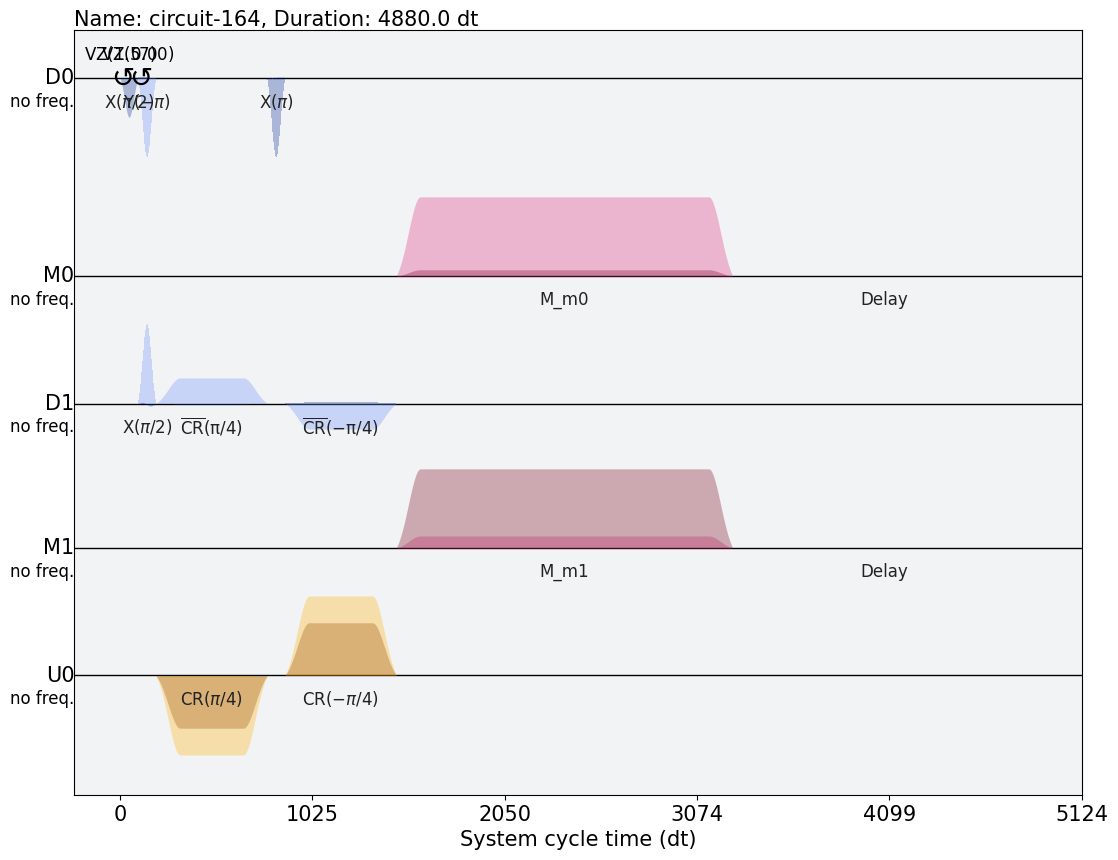

In [14]:
schedule(transpiled_circ, BACKEND).draw()

In [15]:
job = BACKEND.run(transpiled_circ)

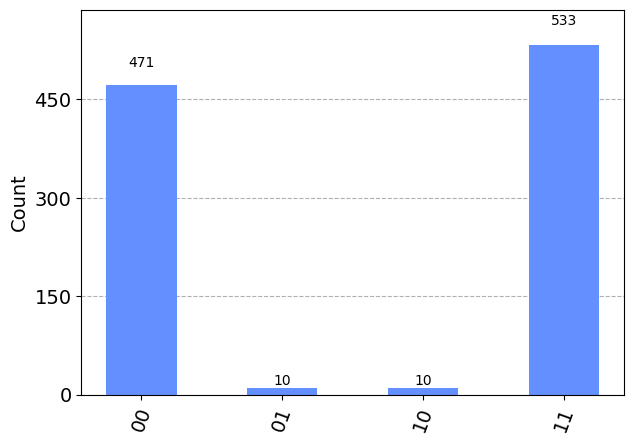

In [16]:
counts = job.result().get_counts()
plot_histogram(counts)

# How to build pulse gate : Transpilation on Fake Hanoi

In [17]:
BACKEND = FakeHanoi()
config = BACKEND.configuration()
print(config.backend_name, config.n_qubits, config.basis_gates)
print(config.coupling_map)

fake_hanoi 27 ['id', 'rz', 'sx', 'x', 'cx', 'reset']
[[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]


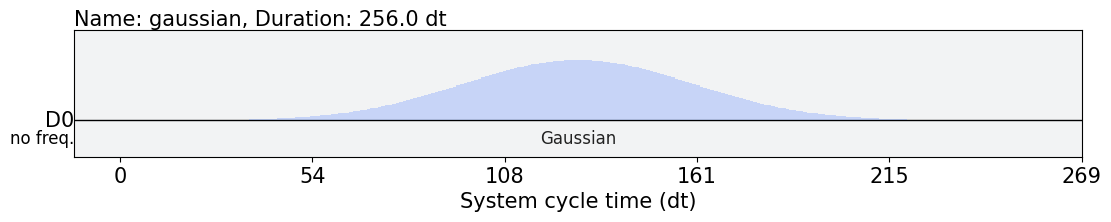

In [18]:
with pulse.build(BACKEND, name='gaussian') as gaussian_q0:
    pulse.play(Gaussian(duration=256, amp=0.2, sigma=128/4), pulse.drive_channel(0))
gaussian_q0.draw()

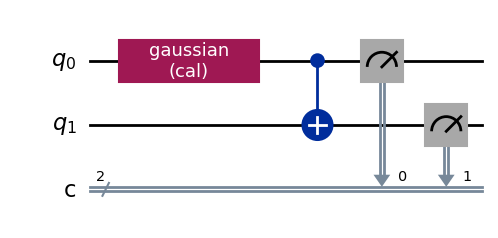

In [19]:
circ = QuantumCircuit(2, 2)
circ.append(Gate('gaussian', 1, []), [0])
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('gaussian', [0], gaussian_q0)
circ.draw('mpl')

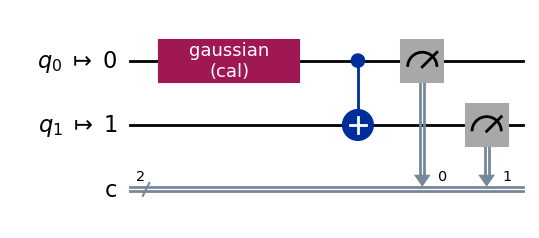

In [20]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

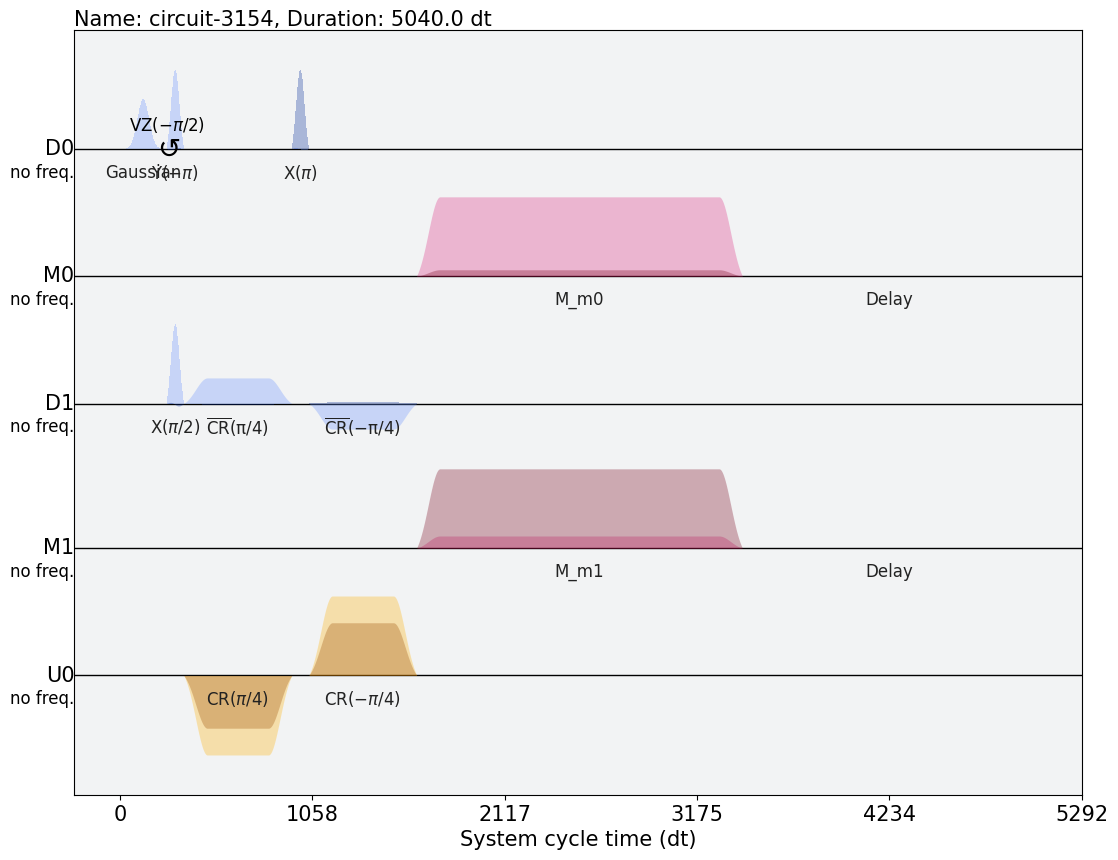

In [21]:
schedule(transpiled_circ, BACKEND).draw()

In [22]:
job = BACKEND.run(transpiled_circ)

In [23]:
job.status()

<JobStatus.ERROR: 'job incurred error'>

In [ ]:
job.result()

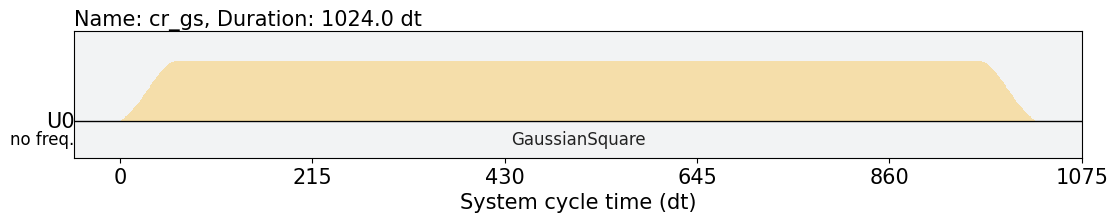

In [25]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(0,1)[0])
cr_gs_q01.draw()

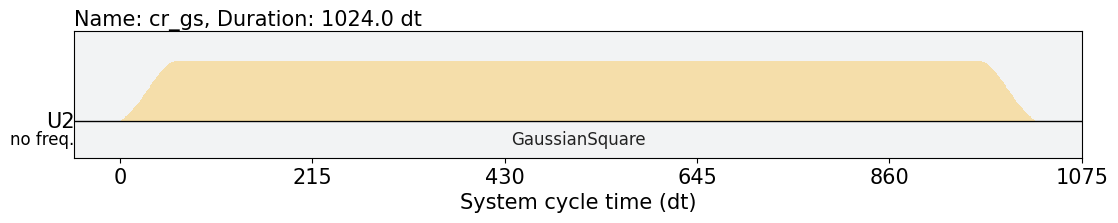

In [26]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q12:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,2)[0])
cr_gs_q12.draw()

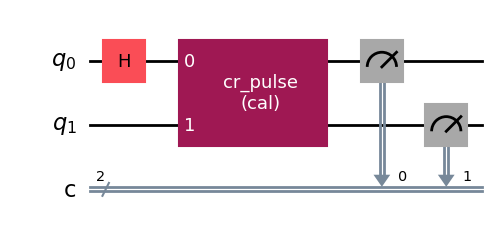

In [27]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.append(Gate('cr_pulse', 2, []), [0,1])
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('cr_pulse', [0,1], cr_gs_q01)
#circ.add_calibration('cr_pulse', [1,2], cr_gs_q12)
circ.draw('mpl')

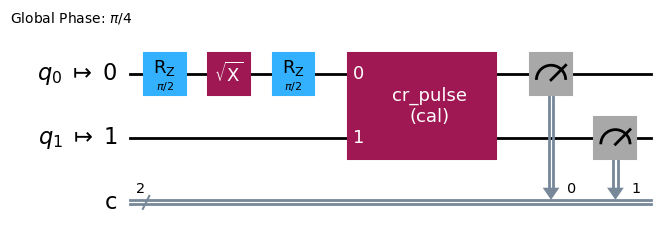

In [28]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

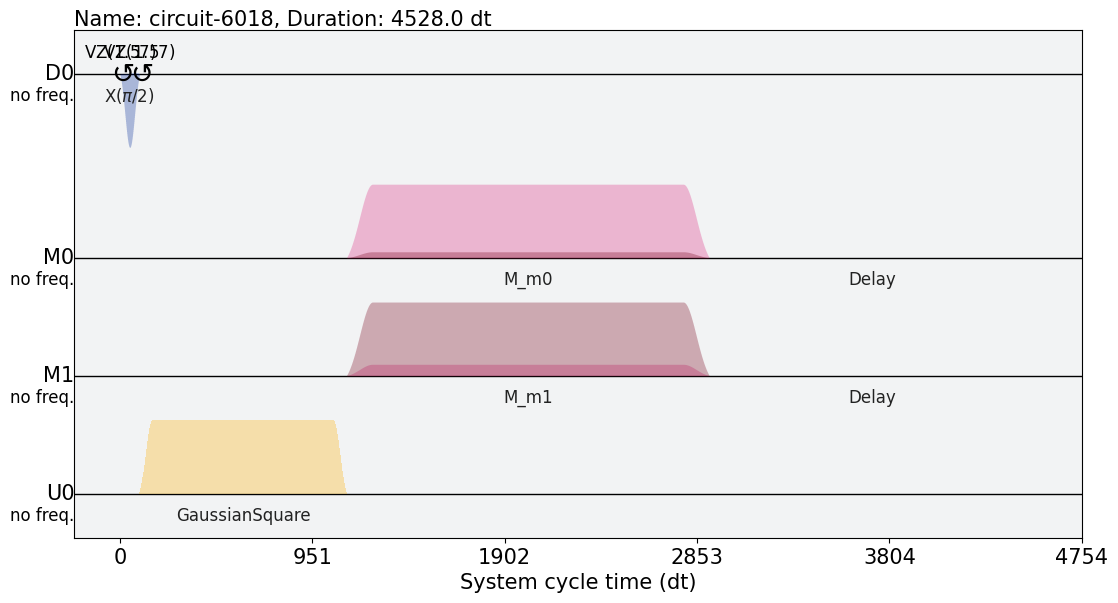

In [29]:
schedule(transpiled_circ, BACKEND).draw()

In [30]:
job = BACKEND.run(transpiled_circ)

In [31]:
job.status()

<JobStatus.ERROR: 'job incurred error'>

# Run on real device :: ibm_kyoto

In [32]:
BACKEND = service.get_backend('ibm_kyoto')

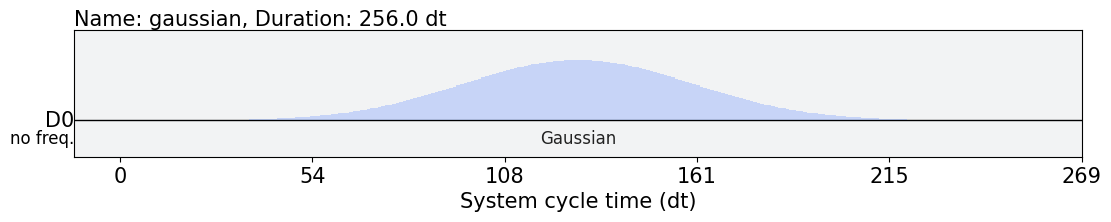

In [33]:
with pulse.build(BACKEND, name='gaussian') as gaussian_q0:
    pulse.play(Gaussian(duration=256, amp=0.2, sigma=128/4), pulse.drive_channel(0))
gaussian_q0.draw()

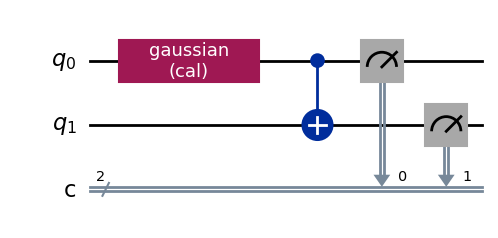

In [34]:
circ = QuantumCircuit(2, 2)
circ.append(Gate('gaussian', 1, []), [0])
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('gaussian', [0], gaussian_q0)
circ.draw('mpl')

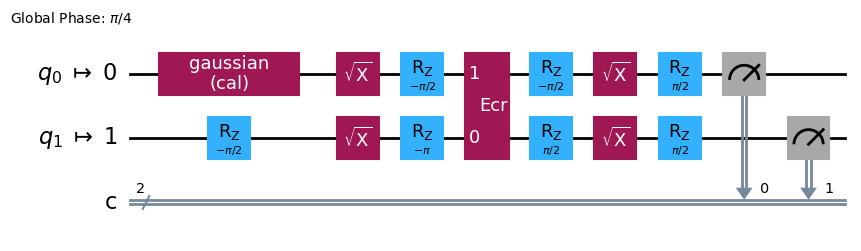

In [35]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

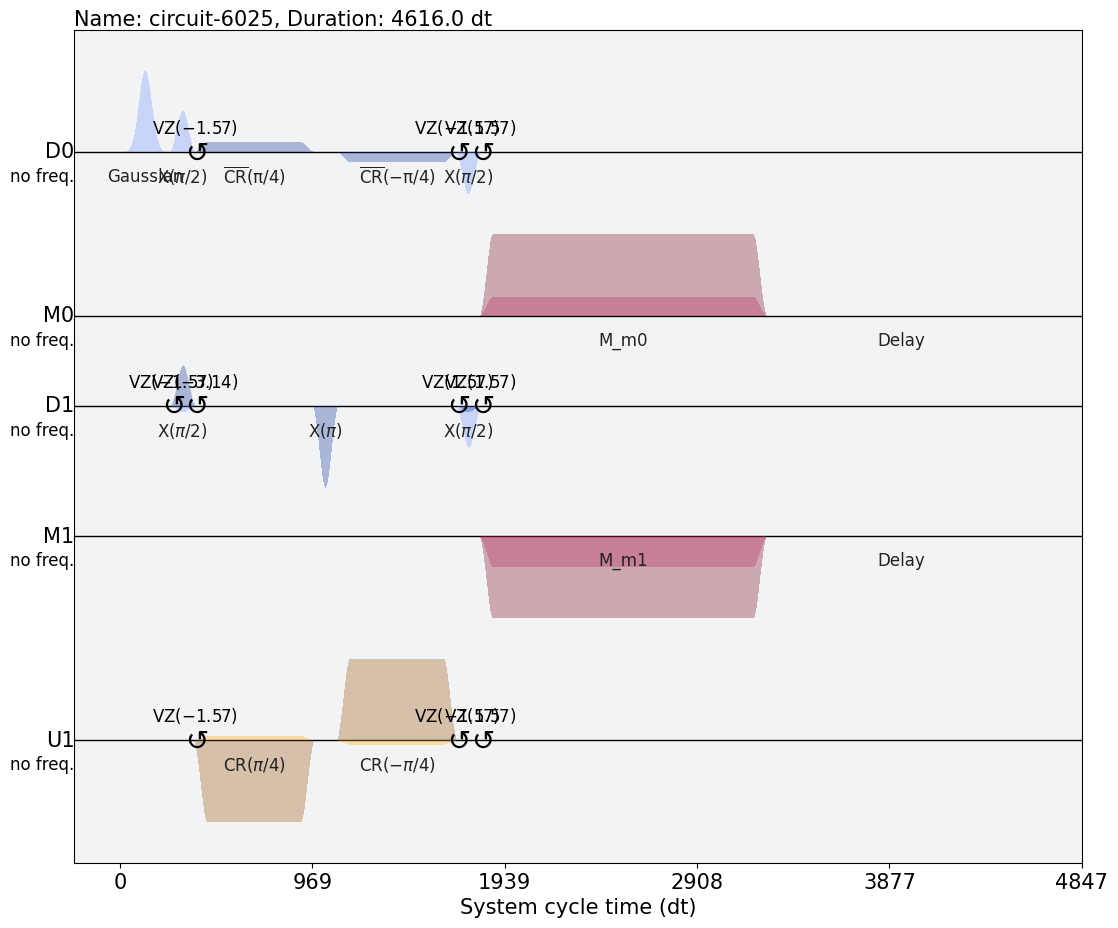

In [36]:
schedule(transpiled_circ, BACKEND).draw()

In [92]:
job = BACKEND.run(transpiled_circ)

In [ ]:
job.job_id()

In [51]:
#job = service.job('job_id_xxxxxxxxxxx')
job.status()

<JobStatus.DONE: 'job has successfully run'>

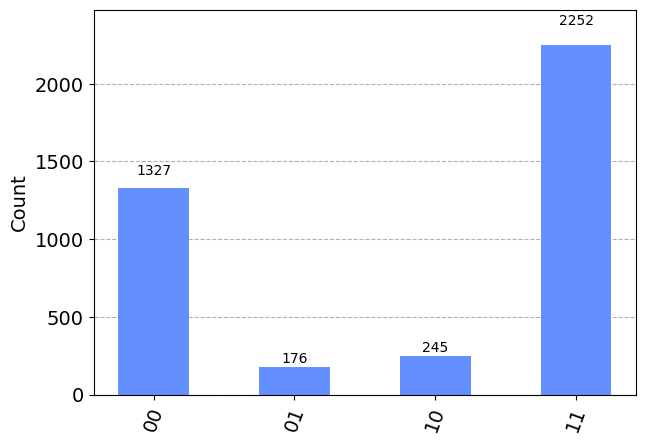

In [53]:
counts = job.result().get_counts()
plot_histogram(counts)

In [ ]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(0,1)[0])
cr_gs_q01.draw()

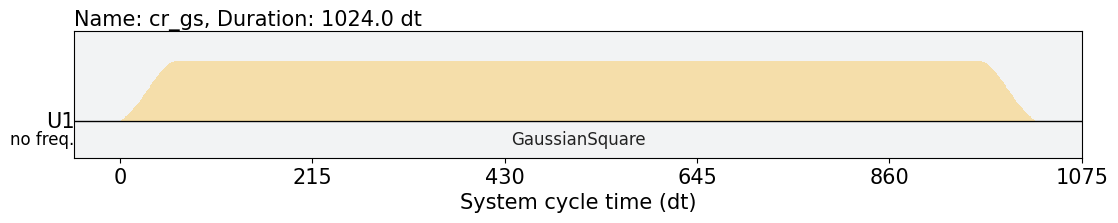

In [41]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q01:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,0)[0])
cr_gs_q01.draw()

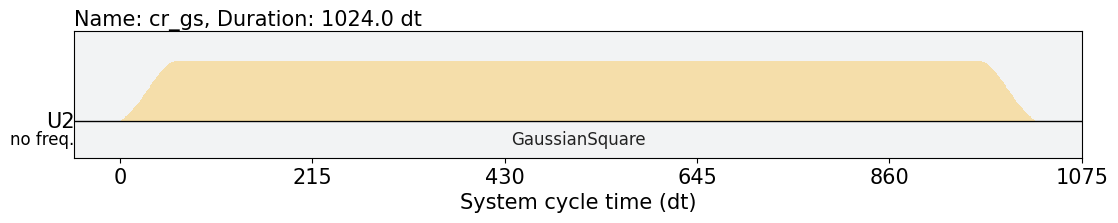

In [42]:
with pulse.build(BACKEND, name='cr_gs') as cr_gs_q12:
    pulse.play(GaussianSquare(duration=1024, amp=0.2, sigma=128/4, width=1024-128), pulse.control_channels(1,2)[0])
cr_gs_q12.draw()

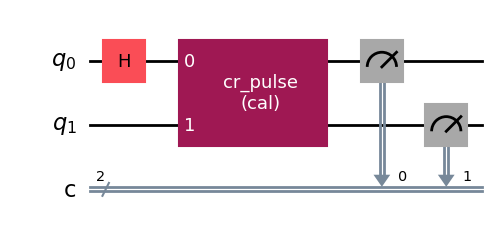

In [43]:
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.append(Gate('cr_pulse', 2, []), [0,1])
circ.measure(0, 0)
circ.measure(1, 1)
circ.add_calibration('cr_pulse', [0,1], cr_gs_q01)
circ.add_calibration('cr_pulse', [1,2], cr_gs_q12)
circ.draw('mpl')

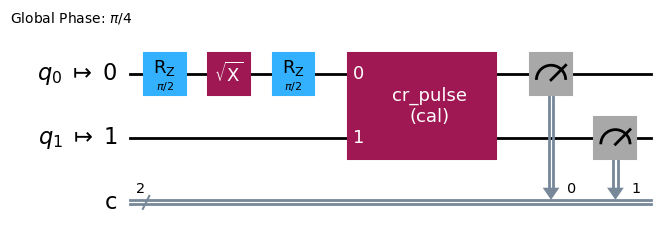

In [44]:
transpiled_circ = transpile(circ, BACKEND, initial_layout=[0,1])
transpiled_circ.draw('mpl', idle_wires=False)

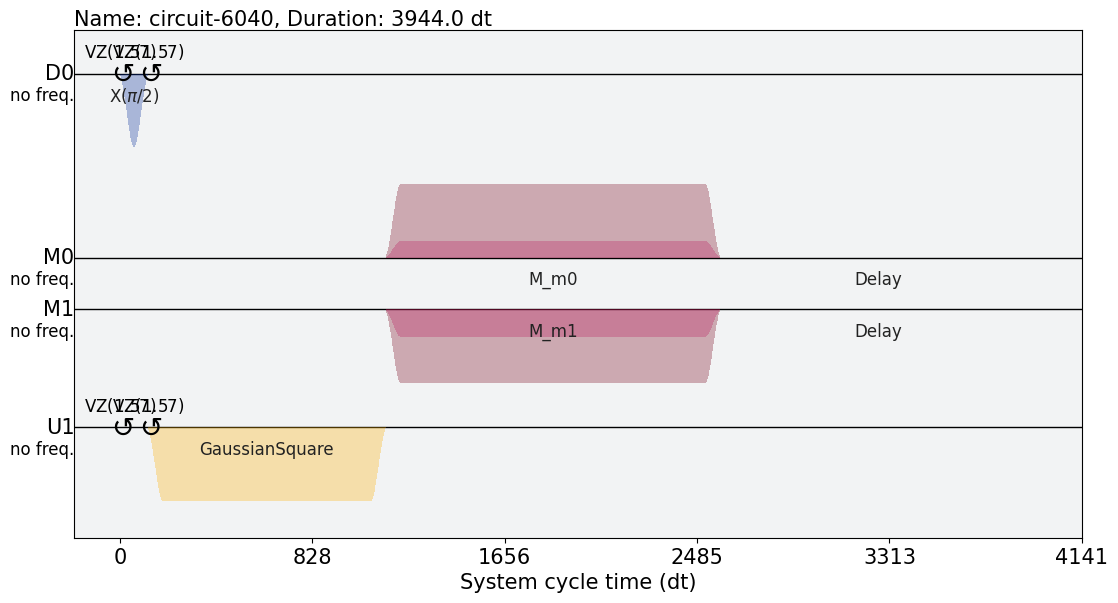

In [45]:
schedule(transpiled_circ, BACKEND).draw()

In [45]:
job = BACKEND.run(transpiled_circ)

In [ ]:
job.job_id()

In [49]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

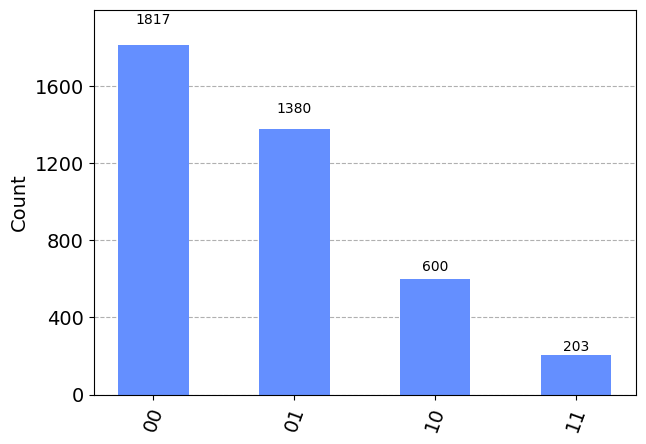

In [50]:
counts = job.result().get_counts()
plot_histogram(counts)

# Rabi Oscillation Experiments

## Functions

In [55]:
def gaussian_pulse_circ(amp, duration, risefall): 
    with pulse.build(BACKEND, name='gaussian') as gaussian:
        pulse.play(Gaussian(duration=duration, amp=amp, sigma=risefall/4), pulse.drive_channel(QUBIT))
    
    circ = QuantumCircuit(1,1)
    circ.name = 'gaussian(%.2f,%d,%d)'%(amp, duration, risefall)
    circ.append(Gate('gaussian', 1, []), [0])
    circ.measure(0,0)
    circ.add_calibration('gaussian', [QUBIT], gaussian)
    return circ

def amp_scan_experiment(amp_step, duration=256, risefall=128, n=100):
    circs = [gaussian_pulse_circ(amp_step*i, duration, risefall) for i in range(100)]
    transpiled_circs = [transpile(circ, BACKEND, initial_layout=[QUBIT]) for circ in circs]
    job = BACKEND.run(transpiled_circs)
    print(job.job_id())
    return job

In [56]:
def gaussian_square_pulse_circ(amp, duration, risefall): 
    with pulse.build(BACKEND, name='gaussian_square') as gaussian_square:
        pulse.play(GaussianSquare(duration=duration, amp=amp, sigma=risefall/4, width=duration-risefall), pulse.drive_channel(QUBIT))
    
    circ = QuantumCircuit(1,1)
    circ.name = 'gaussian_sqaure(%.2f,%d,%d)'%(amp, duration, risefall)
    circ.append(Gate('gaussian_square', 1, []), [0])
    circ.measure(0,0)
    circ.add_calibration('gaussian_square', [QUBIT], gaussian_square)
    return circ

def duration_scan_experiment(duration_step, amp=0.05, risefall=128, n=100):
    circs = [gaussian_square_pulse_circ(amp, risefall+i*duration_step, risefall) for i in range(100)]
    transpiled_circs = [transpile(circ, BACKEND, initial_layout=[QUBIT]) for circ in circs]
    job = BACKEND.run(transpiled_circs)
    print(job.job_id())
    return job

In [57]:
def plot_population(counts):
    shots = sum(counts[0].values())
    pop0_list = [count['0']/shots for count in counts]
    pop1_list = [count['1']/shots for count in counts]
    plt.plot(pop0_list,  marker='o', label='|0>', linestyle = ":")
    plt.plot(pop1_list,  marker='o', label='|1>', linestyle = ":")
    plt.ylabel('Population')
    plt.ylim([-0.05, 1.05])
    plt.legend()

## Experiments on ibm_kyoto

In [58]:
BACKEND = service.get_backend('ibm_kyoto')

### Amplitude_scan

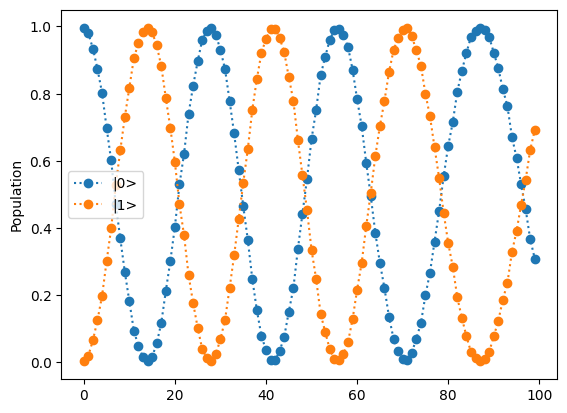

In [64]:
QUBIT = 2
job = amp_scan_experiment(amp_step=0.01)
plot_population(job.result().get_counts())

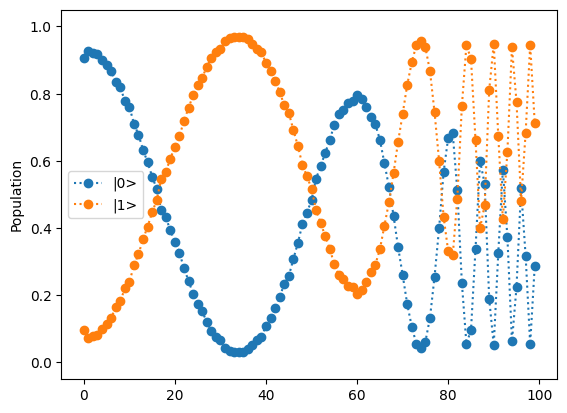

In [62]:
QUBIT = 1
job = amp_scan_experiment(amp_step=0.01)
plot_population(job.result().get_counts())

### Duration_scan

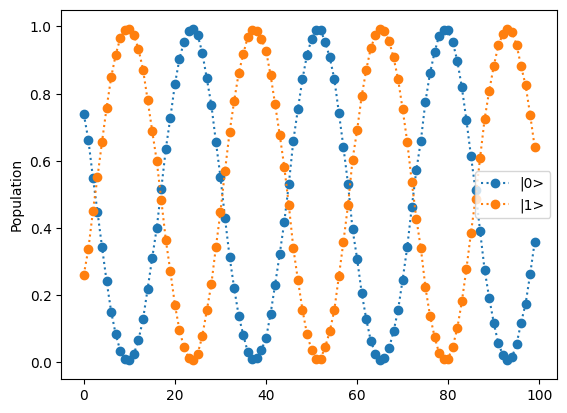

In [61]:
QUBIT = 2
job = duration_scan_experiment(duration_step=16)
plot_population(job.result().get_counts())

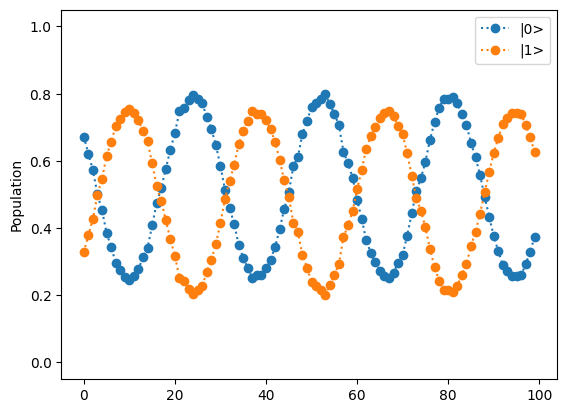

In [59]:
QUBIT = 0
job = duration_scan_experiment(duration_step=16)
plot_population(job.result().get_counts())